In [1]:
import csv
import ast

# create dictionary with odor: [list of chemicals]
with open('../data_binary.csv', 'r') as f:
    odor_chems_dict = csv.DictReader(f)
    odor_chems_dict = {x['Name'].lower() : x['chems'] for x in odor_chems_dict}

# create dictionary with chemical: CID
with open('../molecules.csv', 'r') as f:
    chem_cid_dict = csv.DictReader(f)
    chem_cid_dict = {x['name'].lower() : x['CID'] for x in chem_cid_dict}

def merge(s1, s2):
    s1 = [x.lower().strip() for x in s1.split(',') if x != '']
    s2 = [x.lower().strip() for x in s2.split(',') if x != '']
    return list(set(s1 + s2))

def clean_list(s):
    return [x.strip() for x in s.replace('\n', ',').split(',') if x != '']
# create dictionary with CID: [list of related words]
with open('../details.csv', 'r') as f:
    data = csv.DictReader(f)
    # cid_odor_descript_dict = {x['CID'] : list(filter(lambda chem: chem != '', x['Odor'].replace('\n',',').split(','))) for x in data}
    cid_odor_descript_dict = {x['CID'] : clean_list(x['Odor']) for x in data}

# dict of CID: odor description
with open('../details.csv', 'r') as f:
    data = csv.DictReader(f)
    cid_profile_dict = {x['CID'] : merge(x['Flavor Profile'], x['FEMA Flavor Profile']) for x in data}


In [2]:
print(cid_profile_dict['5281708'])
print(cid_odor_descript_dict['5281708'])

['bitter']
[]


In [19]:
# take an odor (word) and return a list of related words according to molecular components
def find_related_words(odor):
    chems = ast.literal_eval(odor_chems_dict[odor])
    descriptors = {}
    odor_descriptors = {}
    for chem in chems:
        if chem in chem_cid_dict:
            cid = chem_cid_dict[chem]
            if cid in cid_profile_dict:
                # print(chem, set(list(cid_profile_dict[cid] + cid_odor_descript_dict[cid])))
                for descriptor in cid_profile_dict[cid]:
                    if descriptor == '': continue
                    if descriptor in descriptors:
                        descriptors[descriptor] += 1
                    else:
                        descriptors[descriptor] = 1
                for descriptor in cid_odor_descript_dict[cid]:
                    if descriptor == '': continue
                    if descriptor in odor_descriptors:
                        odor_descriptors[descriptor] += 1
                    else:
                        odor_descriptors[descriptor] = 1
    # print(descriptors)
    # print(odor_descriptors)
    return (descriptors, odor_descriptors)

find_related_words('apple')

({'odorless': 7,
  'sweet': 17,
  'bitter': 19,
  'almond': 2,
  'roasted pepper': 1,
  'bitter almond': 2,
  'strong': 3,
  'malt': 1,
  'cherry': 3,
  'sharp': 1,
  'burnt sugar': 1,
  'grapefruit': 3,
  'flower': 1,
  'floral': 10,
  'balsamic': 1,
  'walnut': 1,
  'phenolic': 2,
  'roasted bread': 1,
  'moss': 1,
  'rose': 2,
  'berry': 2,
  'boiled cherries': 1,
  'burnt': 2,
  'waxy': 5,
  'chemical': 1,
  'aldehydic': 2,
  'mushroom': 2,
  'burnt matches': 1,
  'green': 6,
  'metal': 2,
  'fat': 4,
  'orange': 2,
  'faint': 3,
  'nutty': 3,
  'chocolate': 2,
  'creamy': 5,
  'vanilla': 2,
  'ethereal': 4,
  'medical': 1,
  'alcoholic': 2,
  'oily': 3,
  'fatty': 8,
  'garlic': 2,
  'cheesy': 3,
  'sour': 3,
  'alters several flavor and/or taste characteristics': 1,
  'cocoa': 2,
  'hawthorne': 1,
  'peanut': 2,
  'pungent': 10,
  'nut': 1,
  'honey': 3,
  'hyacinth': 2,
  'clover': 1,
  'geranium': 1,
  'coconut': 1,
  'bay oil': 1,
  'mild': 4,
  'slightly waxy': 1,
  'pear': 4

Ideas: 
1. create clustering (of 20) for odor descriptors as in Shang et al, to plot odor wheel according to the 20 categories for each complex odor compound
2. word2vec cosine similarity to generate hierarchical odor wheel of preset descriptors, then plot complex odor compound using counts (using max of similarities to descriptors with some threshold, ignoring any 'odorless')

In [7]:
import gensim.downloader as api

# load pretrained Word2Vec model
model = api.load("word2vec-google-news-300") # 7 min --> 40 s

In [8]:
# generate unique descriptors
descriptors = set()
for d_set in cid_profile_dict.values():
    for d in d_set:
        descriptors.add(d)

for d_set in cid_odor_descript_dict.values():
    for d in d_set:
        descriptors.add(d)

print(len(descriptors))


1381


In [9]:
import numpy as np

# Filter out words not in the model
words = [word for word in descriptors if word in model]
print(len(words))

# Get the vectors for these words
word_vectors = np.array([model[word] for word in words])

562


In [12]:
from scipy.spatial.distance import euclidean, cosine

shang_descriptors = ['bakery', 'sweet', 'fruit', 'fish', 'garlic', 'spices', 'cold', 'sour', 'burnt', 'acid', 'warm', 'musky', 'sweaty', 'ammonia', 'decayed', 'wood', 'grass', 'floral', 'chemical']
shang_word_vectors = np.array([model[word] for word in shang_descriptors])

In [42]:

# create rose plot given a certain word by mapping similarity to shang descriptors
def find_best_descriptor(word):
    if word not in model: return None
    word_vector = model[word]
    similarities = [1 - cosine(word_vector, shang_vector) for shang_vector in shang_word_vectors]
    return shang_descriptors[np.argmax(similarities)]

def find_frequencies(word):
    descriptor_frequencies = {desc: 0 for desc in shang_descriptors}
    word_descriptors, odor_descriptors = find_related_words(word)
    for word, count in word_descriptors.items():
        best_shang_descriptor = find_best_descriptor(word)
        if best_shang_descriptor is not None:
            descriptor_frequencies[best_shang_descriptor] += count
    for word, count in odor_descriptors.items():
        best_shang_descriptor = find_best_descriptor(word)
        if best_shang_descriptor is not None:
            descriptor_frequencies[best_shang_descriptor] += count
    return descriptor_frequencies

print(find_frequencies('egg'))
    
    


{'bakery': 2, 'sweet': 14, 'fruit': 9, 'fish': 4, 'garlic': 8, 'spices': 2, 'cold': 0, 'sour': 5, 'burnt': 2, 'acid': 3, 'warm': 0, 'musky': 0, 'sweaty': 5, 'ammonia': 6, 'decayed': 5, 'wood': 5, 'grass': 7, 'floral': 8, 'chemical': 6}


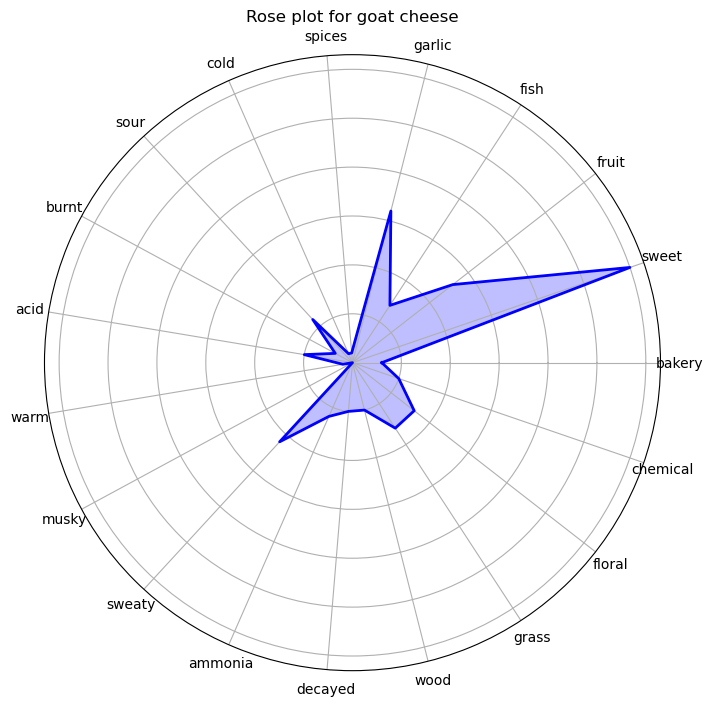

In [44]:
import matplotlib.pyplot as plt
word = 'goat cheese'
data = find_frequencies(word)

# plot as rose histogram
# Convert the keys to angles in radians
labels = list(data.keys())
values = np.array(list(data.values()))
angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=False).tolist()

# The 'values' array needs to be repeated to close the circular graph
values = np.concatenate((values, [values[0]]))
angles += angles[:1]

# Create the polar plot
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

# Plot the data
ax.fill(angles, values, color='blue', alpha=0.25)
ax.plot(angles, values, color='blue', linewidth=2)

# Add labels to each sector
ax.set_yticklabels([])  # Hide radial labels
ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels)
ax.set_title(f"Rose plot for {word}")

plt.show()